In [1]:
from DMpy.model import DMModel, Parameter
from DMpy.learning import dual_lr_qlearning, rescorla_wagner
from DMpy.observation import softmax
import pandas as pd
import numpy as np
import theano
import seaborn as sns
import matplotlib.pyplot as plt
theano.config.mode = 'Mode'   # this is necessary to make theano play nicely in ipython for some reason

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

# Model fitting settings

# Priors
alpha_mean = 0.5
alpha_var = 5

beta_mean = 3
beta_var = 10

# Number of ADVI iterations
advi_n = 22000

# Demonstrating the benefits of hierarchical modelling

First we'll run simulations with a single group just to demonstrate where hierarchical modelling is useful. This isn't the best example as the data is relatively "clean" and our parameter estimates will be fairly precise to begin with, but it'll give an idea of how hierarchical modelling can be helpful.

### Task

We'll use a simple learning task where subjects the reward value of a stimulus based on a series of reward and no-reward outcomes. The outcomes are presented as a series of 0s and 1s - 1s indicate a reward while 0s indicate no reward. We have 200 trials, which is fairly representative of tasks used in clinical studies.

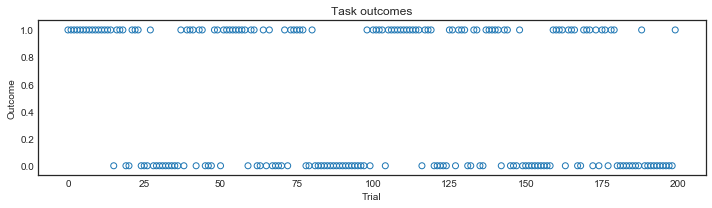

In [2]:
outcomes = np.loadtxt('task_outcomes/example_outcomes.txt')
plt.figure(figsize=(10, 3))
plt.scatter(range(0, len(outcomes)), outcomes, edgecolors='tab:blue', facecolors='None');
plt.xlabel("Trial")
plt.ylabel("Outcome")
plt.title("Task outcomes")
plt.tight_layout()

### Model

The model we'll use is an extension of a standard Rescorla-Wagner model with two learning rates, one for better than expected outcomes and one from worse than expected outcomes (taken from Lefebrvre et al., 2017, Nature Human Behaviour).

Value on each trial is updated according to:

\begin{equation*}
\delta = (outcome - Q_t)
\end{equation*}

\begin{equation*}
Q_{t+1} = Q_t + \begin{matrix}
\alpha^+ \cdot \delta&\text{if } \delta > 0 \\
\alpha^- \cdot \delta&\text{if } \delta < 0
\end{matrix}
\end{equation*}

Priors here are normally distributed.

In [3]:
value = Parameter(r'$Q$', 'fixed', mean=0.5, dynamic=True)

# Softmax inverse temperature parameter
b = Parameter(r'$\beta$', 'normal', lower_bound=0, upper_bound=10, mean=beta_mean, variance=beta_var)

# Positive and negative learning rates, normally distributed between 0 and 1
alpha_p = Parameter(r'$\alpha^p$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
alpha_n = Parameter(r'$\alpha^n$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)

# Create dual learning rate model instance
model = DMModel(dual_lr_qlearning, [value, alpha_p, alpha_n], softmax, [b], name='Dual learning rate',
                       logp_function = 'bernoulli')


We can simulate the behaviour of various agents responding to these outcomes with different parameter values. Here we're simulating combinations of parameter values for the three free parameters in the model, the two learning rates and the softmax temperature parameter.

In [4]:
sim_results, sim_result_file = model.simulate(outcomes, learning_parameters={r'$Q$': 0.5,
                                                                             r'$\alpha^p$': np.arange(0, 1, 0.2),
                                                                             r'$\alpha^n$': np.arange(0, 1, 0.2)},
               observation_parameters={r'$\beta$': np.arange(1, 4, 0.4)}, combinations=True, 
                                              output_file='two_group_sim.txt')

c:\users\toby\onedrive - university college london\dmpy\DMpy\model.py:1141: Warning: Fewer outcome lists than simulated subjects, attempting to use same outcomes for each subject (number of outcome lists = 1, number of subjects = 200
  p_combinations.shape[0]), Warning)


Saving simulated responses to two_group_sim.txt
Finished simulating


## Non-hierarchical fitting

Fitting the model to this simulated data then allows us to see how well we can recover the parameters we used to simulate the data. First we'll do this in a non-hierarchical manner.

Loading multi-subject data with 200 subjects, 1 runs per subject
Loaded data, 200 subjects with 200 trials * 1 runs
Created model

-------------------Fitting model using ADVI-------------------

Performing non-hierarchical model fitting for 200 subjects


Average Loss = 19,317: 100%|█████████████████████████████████████████████████████| 22000/22000 [06:36<00:00, 55.43it/s]
Finished [100%]: Average Loss = 19,317


Done

PARAMETER ESTIMATES

Performing parameter recovery tests...
Finished model fitting in 410.486876668 seconds


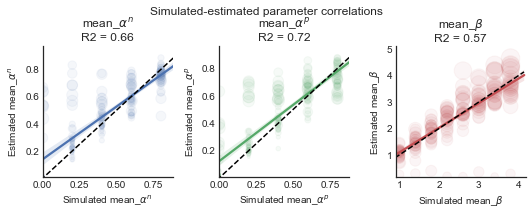

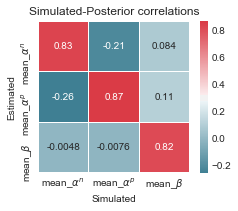

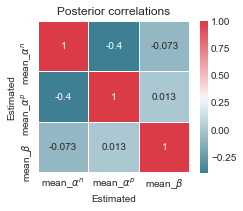

In [5]:
model.fit(sim_result_file, fit_method='variational', suppress_table=True, recovery=True, 
          fit_kwargs=dict(n=advi_n), plot=False)
beta_values = {'method': [], 'value': []}
beta_values['value'] += model.parameter_table[[c for c in model.parameter_table if 'beta' in c and 'mean' in c]].values.flatten().tolist()
beta_values['method'] += ['non_hierarchical'] * len(model.parameter_table)

## Hierarchical fitting

The non-hierarchical fit isn't too bad, as shown by the high correlations between simulated and recovered parameter values and the relatively high $R^2$ values. However it's not perfect, and the parameter estimates for the $\beta$ parameter have high variance (as indicated by the larger points on the scatter plots). In scenarios like this, where parameter estimates are noisy (often due to data of limited quality or quantity), hierarchical fitting methods can help to improve their precision by using group-level effects to inform individual ones. We can demonstrate this as follows.

Loading multi-subject data with 200 subjects, 1 runs per subject
Loaded data, 200 subjects with 200 trials * 1 runs
Created model

-------------------Fitting model using ADVI-------------------

Performing hierarchical model fitting for 200 subjects


Average Loss = 18,119: 100%|█████████████████████████████████████████████████████| 22000/22000 [07:40<00:00, 47.82it/s]
Finished [100%]: Average Loss = 18,118


Done

PARAMETER ESTIMATES

Performing parameter recovery tests...
Finished model fitting in 478.192341348 seconds


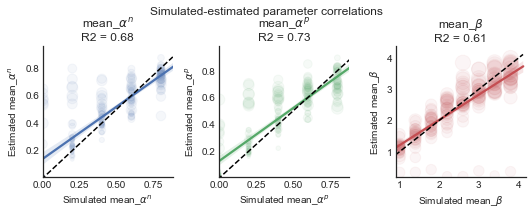

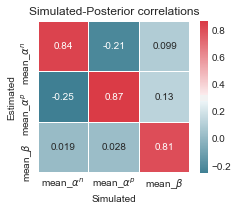

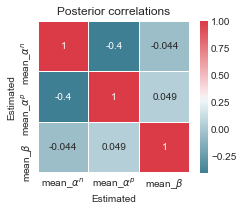

In [6]:
q = Parameter(r'$Q$', 'fixed', mean=0.5, dynamic=True)
alpha_p = Parameter(r'$\alpha^p$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
alpha_n = Parameter(r'$\alpha^n$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
b = Parameter(r'$\beta$', 'normal', lower_bound=0, upper_bound=10, mean=beta_mean, variance=beta_var)
model = DMModel(dual_lr_qlearning, [value, alpha_p, alpha_n], softmax, [b], name='Dual learning rate',
                       logp_function = 'bernoulli')
model.fit(sim_result_file, fit_method='variational', suppress_table=True, recovery=True, hierarchical=True,
          fit_kwargs=dict(n=advi_n), plot=False)
beta_values['value'] += model.parameter_table[[c for c in model.parameter_table if 'beta' in c and 'mean' in c]].values.flatten().tolist()
beta_values['method'] += ['hierarchical'] * len(model.parameter_table)

The $\beta$ parameter in particular is recovered more accurately when using hierarchical fitting. We can see how the beta estimates have shrunk towards the group mean by plotting them.

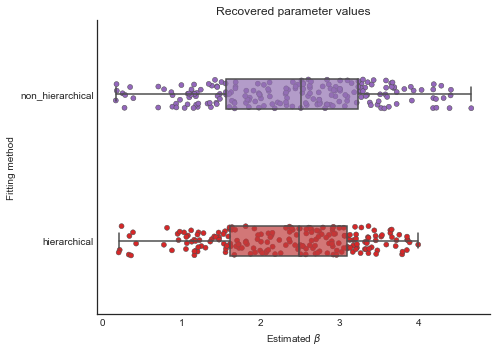

In [7]:
beta_values_df = pd.DataFrame(beta_values)
# sns.factorplot(x="method", y="value", data=beta_values_df, jitter=True);

plt.figure(figsize=(7, 5))
sns.stripplot(x="value", y="method", data=beta_values_df, jitter=True, color=".7", 
              linewidth=0.5, alpha=1, palette=['tab:purple', 'tab:red'], zorder=1);
ax = sns.boxplot(x="value", y="method", data=beta_values_df, palette=['tab:purple', 'tab:red'], whis=np.inf,
           width=0.2, boxprops={"zorder":10}, whiskerprops={'zorder':10}, medianprops={'zorder':11});
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
plt.title("Recovered parameter values");
plt.xlabel("Estimated $\\beta$");
plt.ylabel("Fitting method");
sns.despine()
plt.tight_layout()

## Two groups, hierarchical fitting, $d$=0.3

Hierarchical fitting could potentially be a problem when we have multiple groups of subjects. A $d$ of 0.3 is fairly standard in clinical research and is probably relatively representative of the sort of differences we're looking for in reality, so we'll create two groups of simulated subjects with a difference in $\beta$ values of this magnitude.

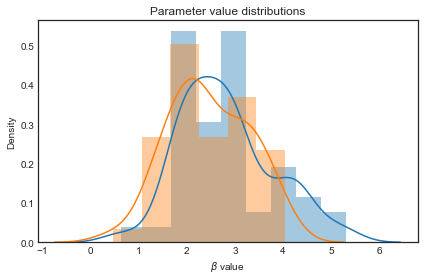

In [15]:
n_groupA = 50
n_groupB = 50

alpha_p_values = np.random.normal(0.3, 0.05, n_groupA + n_groupB)
alpha_n_values = np.random.normal(0.3, 0.05, n_groupA + n_groupB)

beta_values_a = np.random.normal(2.5, 1, n_groupA)
beta_values_b = np.random.normal(2.8, 1, n_groupB)

beta = np.concatenate([beta_values_a, beta_values_b])

sns.distplot(beta_values_a, label="Group A, $\mu$ = 2, $\sigma$ = 0.5", color='tab:blue');
sns.distplot(beta_values_b, label="Group B, $\mu$ = 3, $\sigma$ = 0.5", color='tab:orange');
plt.xlabel("$\\beta$ value")
plt.ylabel("Density")
plt.title("Parameter value distributions")
plt.tight_layout()


### Simulation

Once again we simulate data from this distribution of parameters.

In [16]:
sim_results, sim_result_file = model.simulate(outcomes, learning_parameters={r'$Q$': [0.5] * (n_groupA + n_groupB),
                                                                             r'$\alpha^p$': alpha_p_values,
                                                                             r'$\alpha^n$': alpha_n_values},
               observation_parameters={r'$\beta$': beta}, response_format='discrete', combinations=False,
                                              output_file='two_group_sim_d03.txt')


Saving simulated responses to two_group_sim_d03.txt
Finished simulating


### Non-hierarchical fitting

Loading multi-subject data with 100 subjects, 1 runs per subject
Loaded data, 100 subjects with 200 trials * 1 runs
Created model

-------------------Fitting model using ADVI-------------------

Performing non-hierarchical model fitting for 100 subjects


Average Loss = 11,010: 100%|█████████████████████████████████████████████████████| 22000/22000 [04:30<00:00, 81.38it/s]
Finished [100%]: Average Loss = 11,010


Done

PARAMETER ESTIMATES

Performing parameter recovery tests...
Finished model fitting in 281.178379104 seconds


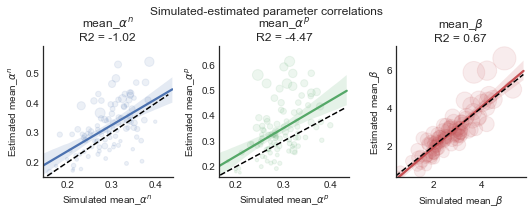

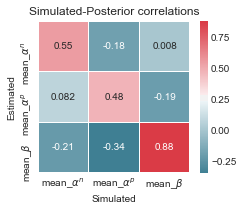

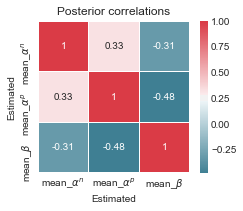

In [17]:
q = Parameter(r'$Q$', 'fixed', mean=0.5, dynamic=True)
alpha_p = Parameter(r'$\alpha^p$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
alpha_n = Parameter(r'$\alpha^n$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
b = Parameter(r'$\beta$', 'normal', lower_bound=0, upper_bound=10, mean=beta_mean, variance=beta_var)
model = DMModel(dual_lr_qlearning, [value, alpha_p, alpha_n], softmax, [b], name='Dual learning rate',
                       logp_function = 'bernoulli')
model.fit(sim_result_file, fit_method='variational', suppress_table=True, recovery=True, 
          fit_kwargs=dict(n=advi_n), plot=False)
non_hierarchical_params = model.parameter_table

### Hierarchical fitting

Loading multi-subject data with 100 subjects, 1 runs per subject
Loaded data, 100 subjects with 200 trials * 1 runs
Created model

-------------------Fitting model using ADVI-------------------

Performing hierarchical model fitting for 100 subjects


Average Loss = 10,321: 100%|████████████████████████████████████████████████████| 22000/22000 [03:39<00:00, 100.07it/s]
Finished [100%]: Average Loss = 10,321


Done

PARAMETER ESTIMATES

Performing parameter recovery tests...
Finished model fitting in 230.789480317 seconds


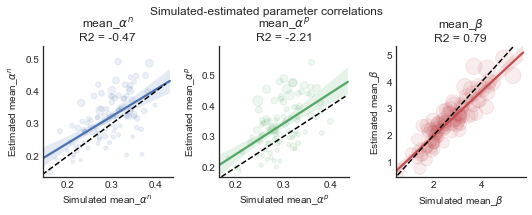

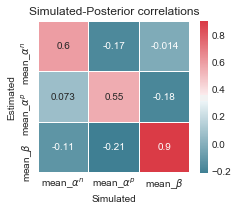

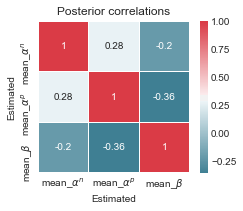

In [21]:
q = Parameter(r'$Q$', 'fixed', mean=0.5, dynamic=True)
alpha_p = Parameter(r'$\alpha^p$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
alpha_n = Parameter(r'$\alpha^n$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
b = Parameter(r'$\beta$', 'normal', lower_bound=0, upper_bound=10, mean=beta_mean, variance=beta_var)
model = DMModel(dual_lr_qlearning, [value, alpha_p, alpha_n], softmax, [b], name='Dual learning rate',
                       logp_function = 'bernoulli')
model.fit(sim_result_file, fit_method='variational', suppress_table=True, recovery=True, hierarchical=True,
          fit_kwargs=dict(n=advi_n), plot=False)
hierarchical_params = model.parameter_table


True effect size = 0.39
Non-hierarchical effect size = 0.28
Hierarchical effect size = 0.29


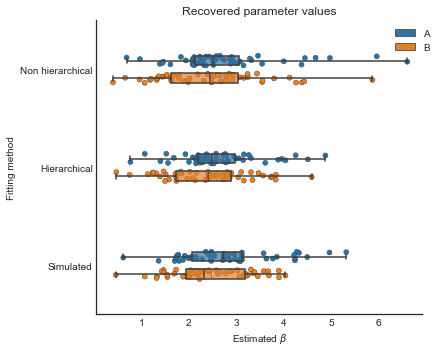

In [22]:
beta_values_d03 = {'method': [], 'value': [], 'group': []}
beta_values_d03['value'] += non_hierarchical_params[[c for c in non_hierarchical_params if 'beta' in c and 'mean' in c]].values.flatten().tolist()
beta_values_d03['method'] += ['Non hierarchical'] * len(non_hierarchical_params)
beta_values_d03['group'] += ['A'] * n_groupA + ['B'] * n_groupB
beta_values_d03['value'] += hierarchical_params[[c for c in hierarchical_params if 'beta' in c and 'mean' in c]].values.flatten().tolist()
beta_values_d03['method'] += ['Hierarchical'] * len(hierarchical_params)
beta_values_d03['group'] += ['A'] * n_groupA + ['B'] * n_groupB
beta_values_d03['value'] += np.concatenate([beta_values_a, beta_values_b]).tolist()
beta_values_d03['method'] += ['Simulated'] * len(model.parameter_table)
beta_values_d03['group'] += ['A'] * n_groupA + ['B'] * n_groupB
beta_values_d03['Subject'] = np.tile(np.arange(0, n_groupA + n_groupB), 3)

beta_values_d03 = pd.DataFrame(beta_values_d03)

plt.figure(figsize=(7, 5))
sns.stripplot(x="value", y="method", hue='group', data=beta_values_d03, jitter=True, color=".7", dodge=True, spacing=0.45,
              linewidth=0.5, alpha=1, palette=['tab:blue', 'tab:orange'] * 3, zorder=1);
ax = sns.boxplot(x="value", y="method", hue='group', data=beta_values_d03, dodge=True, spacing=1.8,
                 palette=['tab:blue', 'tab:orange'] * 3, whis=np.inf, showmeans=True, meanline=True, 
                 meanprops={'zorder': 12, 'linewidth': 1},
           width=0.2, boxprops={"zorder":10}, whiskerprops={'zorder':10}, medianprops={'zorder':11});
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
plt.title("Recovered parameter values");
plt.xlabel("Estimated $\\beta$");
plt.ylabel("Fitting method");
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1))
sns.despine()
plt.tight_layout()

print "True effect size = {0}".format(np.round(cohen_d(beta_values_a, beta_values_b), 2))
print "Non-hierarchical effect size = {0}".format(np.round(cohen_d(beta_values_d03[beta_values_d03.method == 
                                                                      'Non hierarchical'].value[:50], 
             beta_values_d03[beta_values_d03.method == 'Non hierarchical'].value[50:]), 2))
print "Hierarchical effect size = {0}".format(np.round(cohen_d(beta_values_d03[beta_values_d03.method == 
                                                                      'Hierarchical'].value[:50], 
             beta_values_d03[beta_values_d03.method == 'Hierarchical'].value[50:]), 2))

Interestingly we see an underestimation of the true effect with both fitting methods, but this doesn't seem to be affected by whether we're using hiearchical or non-hierarchical fitting.

## Fitting using wider priors

The priors we used previously were already quite uninformative, but it's possible they could still be responsible for the underestimation of the true effect. We can test this using wider priors.

In [27]:
# Priors
alpha_mean = 0.5
alpha_var = 500

beta_mean = 3
beta_var = 1000

Loading multi-subject data with 100 subjects, 1 runs per subject
Loaded data, 100 subjects with 200 trials * 1 runs
Created model

-------------------Fitting model using ADVI-------------------

Performing non-hierarchical model fitting for 100 subjects


Average Loss = 12,391: 100%|████████████████████████████████████████████████████| 22000/22000 [03:32<00:00, 103.70it/s]
Finished [100%]: Average Loss = 12,391


Done

PARAMETER ESTIMATES

Performing parameter recovery tests...
Finished model fitting in 221.007015097 seconds


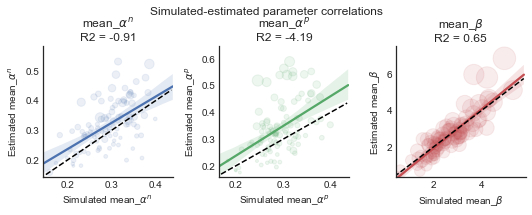

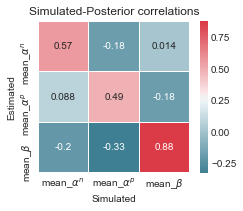

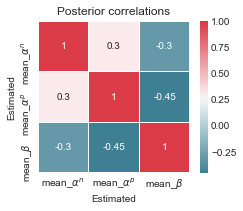

In [28]:
q = Parameter(r'$Q$', 'fixed', mean=0.5, dynamic=True)
alpha_p = Parameter(r'$\alpha^p$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
alpha_n = Parameter(r'$\alpha^n$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
b = Parameter(r'$\beta$', 'normal', lower_bound=0, upper_bound=10, mean=beta_mean, variance=beta_var)
model = DMModel(dual_lr_qlearning, [value, alpha_p, alpha_n], softmax, [b], name='Dual learning rate',
                       logp_function = 'bernoulli')
model.fit(sim_result_file, fit_method='variational', suppress_table=True, recovery=True, 
          fit_kwargs=dict(n=advi_n), plot=False)
non_hierarchical_params = model.parameter_table

Loading multi-subject data with 100 subjects, 1 runs per subject
Loaded data, 100 subjects with 200 trials * 1 runs
Created model

-------------------Fitting model using ADVI-------------------

Performing hierarchical model fitting for 100 subjects


Average Loss = 10,332: 100%|████████████████████████████████████████████████████| 22000/22000 [03:33<00:00, 103.06it/s]
Finished [100%]: Average Loss = 10,332


Done

PARAMETER ESTIMATES

Performing parameter recovery tests...
Finished model fitting in 224.023684299 seconds


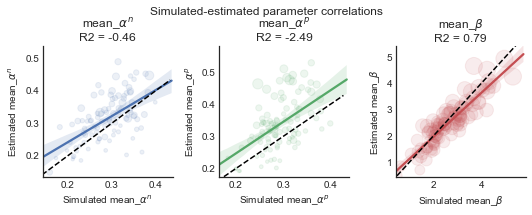

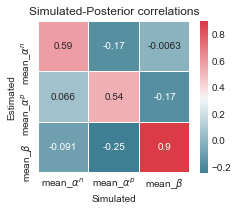

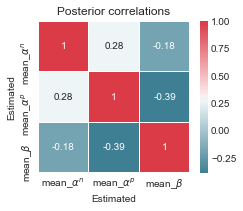

In [29]:
q = Parameter(r'$Q$', 'fixed', mean=0.5, dynamic=True)
alpha_p = Parameter(r'$\alpha^p$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
alpha_n = Parameter(r'$\alpha^n$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
b = Parameter(r'$\beta$', 'normal', lower_bound=0, upper_bound=10, mean=beta_mean, variance=beta_var)
model = DMModel(dual_lr_qlearning, [value, alpha_p, alpha_n], softmax, [b], name='Dual learning rate',
                       logp_function = 'bernoulli')
model.fit(sim_result_file, fit_method='variational', suppress_table=True, recovery=True, hierarchical=True,
          fit_kwargs=dict(n=advi_n), plot=False)
hierarchical_params = model.parameter_table


True effect size = 0.39
Non-hierarchical effect size = 0.28
Hierarchical effect size = 0.31


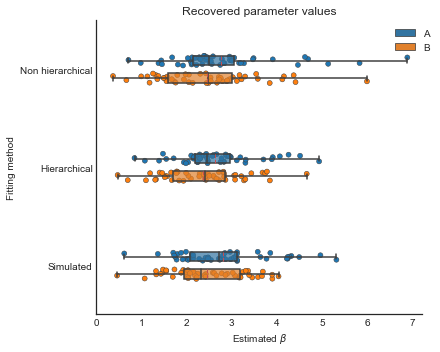

In [30]:
beta_values_d03_wide = {'method': [], 'value': [], 'group': []}
beta_values_d03_wide['value'] += non_hierarchical_params[[c for c in non_hierarchical_params if 'beta' in c and 'mean' in c]].values.flatten().tolist()
beta_values_d03_wide['method'] += ['Non hierarchical'] * len(non_hierarchical_params)
beta_values_d03_wide['group'] += ['A'] * n_groupA + ['B'] * n_groupB
beta_values_d03_wide['value'] += hierarchical_params[[c for c in hierarchical_params if 'beta' in c and 'mean' in c]].values.flatten().tolist()
beta_values_d03_wide['method'] += ['Hierarchical'] * len(hierarchical_params)
beta_values_d03_wide['group'] += ['A'] * n_groupA + ['B'] * n_groupB
beta_values_d03_wide['value'] += np.concatenate([beta_values_a, beta_values_b]).tolist()
beta_values_d03_wide['method'] += ['Simulated'] * len(model.parameter_table)
beta_values_d03_wide['group'] += ['A'] * n_groupA + ['B'] * n_groupB
beta_values_d03_wide['Subject'] = np.tile(np.arange(0, n_groupA + n_groupB), 3)

beta_values_d03_wide = pd.DataFrame(beta_values_d03_wide)

plt.figure(figsize=(7, 5))
sns.stripplot(x="value", y="method", hue='group', data=beta_values_d03_wide, jitter=True, color=".7", dodge=True, spacing=0.45,
              linewidth=0.5, alpha=1, palette=['tab:blue', 'tab:orange'] * 3, zorder=1);
ax = sns.boxplot(x="value", y="method", hue='group', data=beta_values_d03_wide, dodge=True, spacing=1.8,
                 palette=['tab:blue', 'tab:orange'] * 3, whis=np.inf, showmeans=True, meanline=True, 
                 meanprops={'zorder': 12, 'linewidth': 1},
           width=0.2, boxprops={"zorder":10}, whiskerprops={'zorder':10}, medianprops={'zorder':11});
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
plt.title("Recovered parameter values");
plt.xlabel("Estimated $\\beta$");
plt.ylabel("Fitting method");
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1))
sns.despine()
plt.tight_layout()

print "True effect size = {0}".format(np.round(cohen_d(beta_values_a, beta_values_b), 2))
print "Non-hierarchical effect size = {0}".format(np.round(cohen_d(beta_values_d03_wide[beta_values_d03_wide.method == 
                                                                      'Non hierarchical'].value[:50], 
             beta_values_d03_wide[beta_values_d03_wide.method == 'Non hierarchical'].value[50:]), 2))
print "Hierarchical effect size = {0}".format(np.round(cohen_d(beta_values_d03_wide[beta_values_d03_wide.method == 
                                                                      'Hierarchical'].value[:50], 
             beta_values_d03_wide[beta_values_d03_wide.method == 'Hierarchical'].value[50:]), 2))

This doesn't seem to have made things any better, so it seems that this effect size underestimation isn't simply caused by narrow priors.

## MCMC sampling

Previously we've been using variational inference as it's quicker, but this could be affecting our ability to detect the group difference in parameter values. Instead we'll try using MCMC sampling which should provide more accurate parameter estimates

Loading multi-subject data with 100 subjects, 1 runs per subject
Loaded data, 100 subjects with 200 trials * 1 runs
Created model
Fitting model using NUTS
Performing non-hierarchical model fitting for 100 subjects


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [$\beta$_interval__, $\alpha^n$_interval__, $\alpha^p$_interval__]
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [23:15<00:00,  2.51it/s]
The number of effective samples is smaller than 25% for some parameters.



PARAMETER ESTIMATES

Performing parameter recovery tests...
Finished model fitting in 2442.87836785 seconds


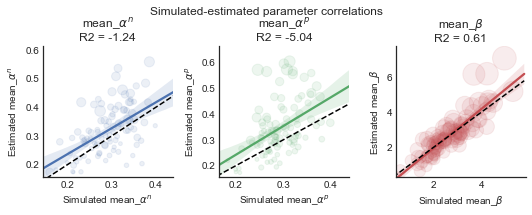

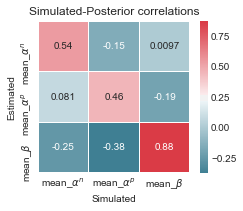

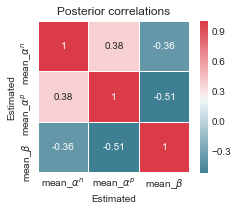

In [35]:
# Priors
alpha_mean = 0.5
alpha_var = 5

beta_mean = 3
beta_var = 10

q = Parameter(r'$Q$', 'fixed', mean=0.5, dynamic=True)
alpha_p = Parameter(r'$\alpha^p$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
alpha_n = Parameter(r'$\alpha^n$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
b = Parameter(r'$\beta$', 'normal', lower_bound=0, upper_bound=10, mean=beta_mean, variance=beta_var)
model = DMModel(dual_lr_qlearning, [value, alpha_p, alpha_n], softmax, [b], name='Dual learning rate',
                       logp_function = 'bernoulli')
model.fit(sim_result_file, fit_method='mcmc', suppress_table=True, recovery=True, 
          sample_kwargs=dict(njobs=1, draws=3000), plot=False)
non_hierarchical_params = model.parameter_table

Loading multi-subject data with 100 subjects, 1 runs per subject
Loaded data, 100 subjects with 200 trials * 1 runs
Created model
Fitting model using NUTS
Performing hierarchical model fitting for 100 subjects


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [$\beta$_interval__, $\beta$_group_sd_interval__, $\beta$_group_mu_interval__, $\alpha^n$_interval__, $\alpha^n$_group_sd_interval__, $\alpha^n$_group_mu_interval__, $\alpha^p$_interval__, $\alpha^p$_group_sd_interval__, $\alpha^p$_group_mu_interval__]
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [10:13<00:00,  5.70it/s]
The number of effective samples is smaller than 10% for some parameters.



PARAMETER ESTIMATES

Performing parameter recovery tests...
Finished model fitting in 1282.9136539 seconds


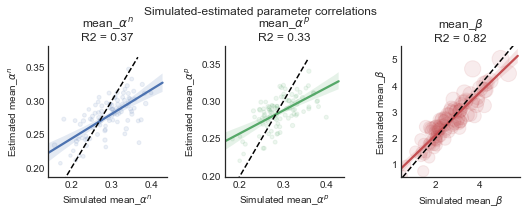

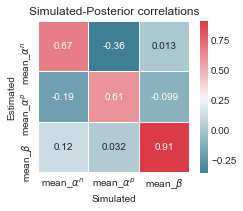

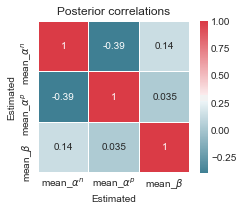

In [38]:
q = Parameter(r'$Q$', 'fixed', mean=0.5, dynamic=True)
alpha_p = Parameter(r'$\alpha^p$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
alpha_n = Parameter(r'$\alpha^n$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
b = Parameter(r'$\beta$', 'normal', lower_bound=0, upper_bound=10, mean=beta_mean, variance=beta_var)
model = DMModel(dual_lr_qlearning, [value, alpha_p, alpha_n], softmax, [b], name='Dual learning rate',
                       logp_function = 'bernoulli')
model.fit(sim_result_file, fit_method='mcmc', suppress_table=True, recovery=True, hierarchical=True,
          sample_kwargs=dict(njobs=1, draws=3000), plot=False)
hierarchical_params = model.parameter_table

True effect size = 0.39
Non-hierarchical effect size = 0.28
Hierarchical effect size = 0.32


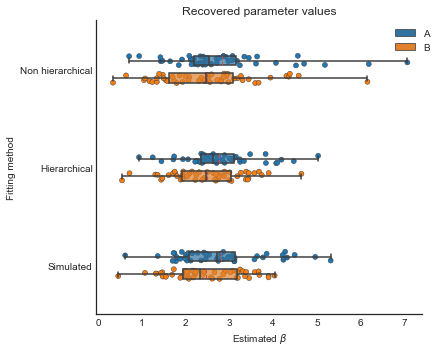

In [51]:
beta_values_d03_wide = {'method': [], 'value': [], 'group': []}
beta_values_d03_wide['value'] += non_hierarchical_params[[c for c in non_hierarchical_params 
                                                          if 'beta' in c and 'mean' in c]].values.flatten().tolist()
beta_values_d03_wide['method'] += ['Non hierarchical'] * len(non_hierarchical_params)
beta_values_d03_wide['group'] += ['A'] * n_groupA + ['B'] * n_groupB

beta_values_d03_wide['value'] += hierarchical_params[[c for c in hierarchical_params 
                                                      if 'beta' in c and 'mean' in c]].values.flatten().tolist()
beta_values_d03_wide['method'] += ['Hierarchical'] * len(hierarchical_params)
beta_values_d03_wide['group'] += ['A'] * n_groupA + ['B'] * n_groupB

beta_values_d03_wide['value'] += np.concatenate([beta_values_a, beta_values_b]).tolist()
beta_values_d03_wide['method'] += ['Simulated'] * len(model.parameter_table)
beta_values_d03_wide['group'] += ['A'] * n_groupA + ['B'] * n_groupB
beta_values_d03_wide['Subject'] = np.tile(np.arange(0, n_groupA + n_groupB), 3)

beta_values_d03_wide = pd.DataFrame(beta_values_d03_wide)

plt.figure(figsize=(7, 5))
sns.stripplot(x="value", y="method", hue='group', data=beta_values_d03_wide, jitter=True, color=".7", dodge=True, spacing=0.45,
              linewidth=0.5, alpha=1, palette=['tab:blue', 'tab:orange'] * 3, zorder=1);
ax = sns.boxplot(x="value", y="method", hue='group', data=beta_values_d03_wide, dodge=True, spacing=1.8,
                 palette=['tab:blue', 'tab:orange'] * 3, whis=np.inf, showmeans=True, meanline=True, 
                 meanprops={'zorder': 12, 'linewidth': 1},
           width=0.2, boxprops={"zorder":10}, whiskerprops={'zorder':10}, medianprops={'zorder':11});
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
plt.title("Recovered parameter values");
plt.xlabel("Estimated $\\beta$");
plt.ylabel("Fitting method");
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1))
sns.despine()
plt.tight_layout()

print "True effect size = {0}".format(np.round(cohen_d(beta_values_a, beta_values_b), 2))
print "Non-hierarchical effect size = {0}".format(np.round(cohen_d(beta_values_d03_wide[beta_values_d03_wide.method == 
                                                                      'Non hierarchical'].value[:50], 
             beta_values_d03_wide[beta_values_d03_wide.method == 'Non hierarchical'].value[50:]), 2))
print "Hierarchical effect size = {0}".format(np.round(cohen_d(beta_values_d03_wide[beta_values_d03_wide.method == 
                                                                      'Hierarchical'].value[:50], 
             beta_values_d03_wide[beta_values_d03_wide.method == 'Hierarchical'].value[50:]), 2))

### Results

The non hierarchical MCMC results look much like the results using variational inference, however the hierarchical ones are far better (even if the simulated-estimated plots don't look like it). 

However, the effect size of the group difference is still underestimated slightly. But most interestingly there's no real difference between hierarchical and non-hierarchical fitting methods, if anything the hierarchical approach recovers a slightly larger difference.

(Note on the plots - the center line on the bar plot indicates the median, means are indicated by dashed red lines although they're a little hard to see)